#EDA on Snowpack, Precipitation & Great Salt Lake Levels
##Julia Duffy | DS 2500 | 04/29/2025

## <font color="#83D3FE">Introduction:</font>
This project seeks to compare the impact of various factors on water levels in the Great Salt Lake. In this analysis, daily snow water equivalent (SWE) measurements from the mountains and daily precipitation records from Salt Lake County are paired with lake-level data from 01-01-2000, through 01-01-2000, to identify which variable has the strongest effect on lake elevation in the Great Salt Lake.

## <font color="#83D3FE">My Question:</font>
Which variable has the stronger relationship to Great Salt Lake elevation: mountain snowpack (SWE) or Salt Lake County precipitation? Also, is there a clear time lag between when snowpack levels increase and when water levels in the Great Salt Lake increase?

## <font color="#83D3FE">The Datasets:</font>
* Brighton SNOTEL SWE: Daily snow-water equivalent (inches) from USDA NRCS.
* Salt Lake County Precipitation: Daily precipitation (inches) from USDA NRCS.
* Great Salt Lake Levels: Daily lake elevation (feet) from USGS NWIS.

## 1. <font color="#83D3FE">Import Libraries</font>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import numpy as np
from scipy.stats import probplot, shapiro
from sklearn.linear_model import LinearRegression

##2. <font color="#83D3FE">Load in the Data</font>

In [ ]:
# Load in the data from a github repository created for this project.
lake_df = pd.read_csv("https://raw.githubusercontent.com/Juliatduffy/final-project-data-2500/refs/heads/main/gsl_water_levels%20(1).csv")
swe_df   = pd.read_csv("https://raw.githubusercontent.com/Juliatduffy/final-project-data-2500/refs/heads/main/brighton_snotel%20(1).csv")
slc_precip = pd.read_csv("https://raw.githubusercontent.com/Juliatduffy/final-project-data-2500/refs/heads/main/gsl_snotel.csv")

##3. <font color="#83D3FE">Clean & Format</font>

In [ ]:
# Convert the date column to be a datetime type
swe_df['Date'] = pd.to_datetime(swe_df['Date'])
lake_df['Date']   = pd.to_datetime(lake_df['Date'])
slc_precip['Date'] = pd.to_datetime(slc_precip['Date'])
slc_precip = slc_precip[(slc_precip['Date'] >= '2000-01-01') & (slc_precip['Date'] <= '2025-01-01')]

# Rename columns in both dataframes to be shorter
swe_df = swe_df.rename(columns={  'Snow Water Equivalent (in) Start of Day Values': 'SWE'  })
lake_df = lake_df.rename(columns={  'Lake_Elevation_ft': 'Level'  })
slc_precip = slc_precip.rename(columns={  'Precipitation Increment (in)': 'Precipitation'  })

# Drop unecessary columns
slc_precip = slc_precip[['Date','Precipitation']]
swe_df = swe_df[['Date', 'SWE']]
lake_df = lake_df[['Date', 'Level']]

##4. <font color="#83D3FE">Inspect the Data</font>
Examine the top and bottom of each dataframe to ensure that they were all loaded and formatted correctly.

In [ ]:
# Print the first 5 rows of the snotel df
swe_df.head()

,Date,SWE
0,1986-09-24,0.0
1,1986-09-25,0.5
2,1986-09-26,0.7
3,1986-09-27,1.1
4,1986-09-28,1.6


In [ ]:
# Print the last 5 rows of the snotel df
swe_df.tail()

,Date,SWE
14093,2025-04-25,13.5
14094,2025-04-26,12.9
14095,2025-04-27,11.9
14096,2025-04-28,11.5
14097,2025-04-29,11.1


In [ ]:
# Print the first 5 rows of the lake level df
lake_df.head()

,Date,Level
0,2000-01-01,4202.5
1,2000-01-02,4202.5
2,2000-01-03,4202.5
3,2000-01-04,4202.4
4,2000-01-05,4202.5


In [ ]:
# Print the last 5 rows of the lake level df
lake_df.tail()

,Date,Level
9128,2024-12-28,4192.4
9129,2024-12-29,4192.5
9130,2024-12-30,4192.6
9131,2024-12-31,4192.5
9132,2025-01-01,4192.5


In [ ]:
# Print the first 5 rows of the SLC Precipitation df
slc_precip.head()

,Date,Precipitation
1918,2000-01-01,0.1
1919,2000-01-02,0.6
1920,2000-01-03,0.1
1921,2000-01-04,0.4
1922,2000-01-05,0.1


In [ ]:
# Print the last 5 rows of the SLC Precipitation df
slc_precip.tail()

,Date,Precipitation
11046,2024-12-28,0.0
11047,2024-12-29,0.0
11048,2024-12-30,0.0
11049,2024-12-31,0.0
11050,2025-01-01,0.0


##5. <font color="#83D3FE">Check for Missing Values</font>
Because there are no missing values in any dataframe, no interpolation is neccessary.

In [ ]:
print("Number of missing values in swe_df:")
print(swe_df.isnull().sum())
print("\n Number of missing values in lake_df:")
print(lake_df.isnull().sum())
print("\n Number of missing values in slc_precip (before interpolation):")
print(slc_precip.isnull().sum())

Number of missing values in swe_df:
Date    0
SWE     0
dtype: int64

 Number of missing values in lake_df:
Date     0
Level    0
dtype: int64

 Number of missing values in slc_precip (before interpolation):
Date             0
Precipitation    0
dtype: int64


##6. <font color="#83D3FE">Merge the Datafames</font>
Merge all three dataframes into one table with a shared 'Date' column.

In [ ]:
# Use a join on the date column to combine the two dataframes
data = pd.merge(swe_df, lake_df, on='Date')
# Merge the result with the third dataframe
data = pd.merge(data, slc_precip, on='Date')

Inspect the top and bottom of the table to ensure that the merge worked as expected.

In [ ]:
# View the first 5 rows of the merged df
data.head()

,Date,SWE,Level,Precipitation
0,2000-01-01,4.6,4202.5,0.1
1,2000-01-02,4.6,4202.5,0.6
2,2000-01-03,4.9,4202.5,0.1
3,2000-01-04,5.1,4202.4,0.4
4,2000-01-05,5.7,4202.5,0.1


In [ ]:
# View the last 5 rows of the merged df
data.tail()

,Date,SWE,Level,Precipitation
9128,2024-12-28,5.4,4192.4,0.0
9129,2024-12-29,6.4,4192.5,0.0
9130,2024-12-30,6.8,4192.6,0.0
9131,2024-12-31,6.8,4192.5,0.0
9132,2025-01-01,6.8,4192.5,0.0


##7. <font color="#83D3FE">Normality Tests</font>
In this section, the key variables of the experiment, SWE, lake level, and precipitation are tested for normality before applying parametric tests.


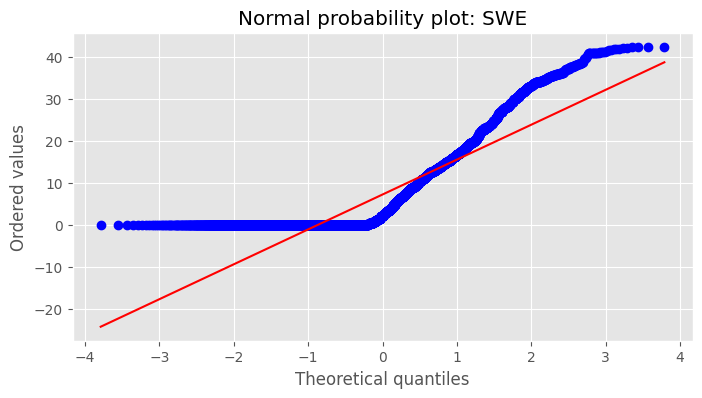

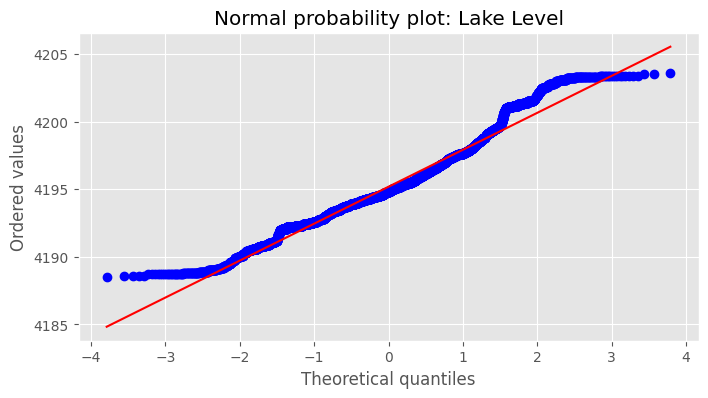

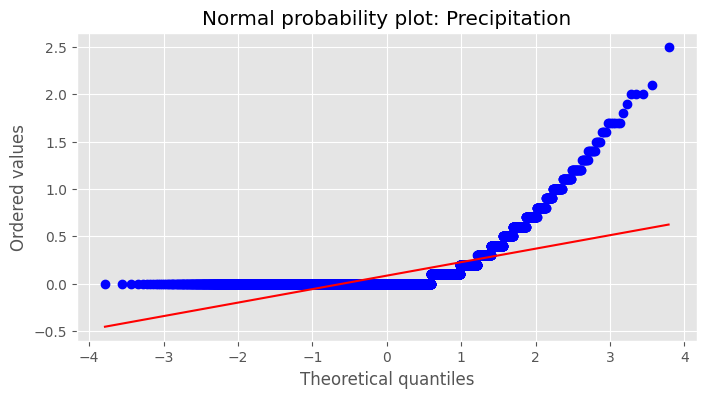

In [ ]:
plt.rcParams['figure.figsize'] = (8, 4)
plt.style.use('ggplot')

probplot(data['SWE'].dropna(), plot=plt)
plt.title("Normal probability plot: SWE")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Ordered values")
plt.show()

probplot(data['Level'].dropna(), plot=plt)
plt.title("Normal probability plot: Lake Level")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Ordered values")
plt.show()

probplot(data['Precipitation'].dropna(), plot=plt)
plt.title("Normal probability plot: Precipitation")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Ordered values")
plt.show()

The no-lag swe data and the precipitation data do not seem linear, so no parametric tests should be performed on that dataset without first transforming the data. Because the next test on these datasets will be a linear regression test, this is not a problem.

##8. <font color="#83D3FE">Time Series Visualization</font>
This is a time series plot of daily SWE values and daily lake level values. It is evident that there is a clear relationship between SWE levels and water levels and there appears to have a short "lag" present in the data.

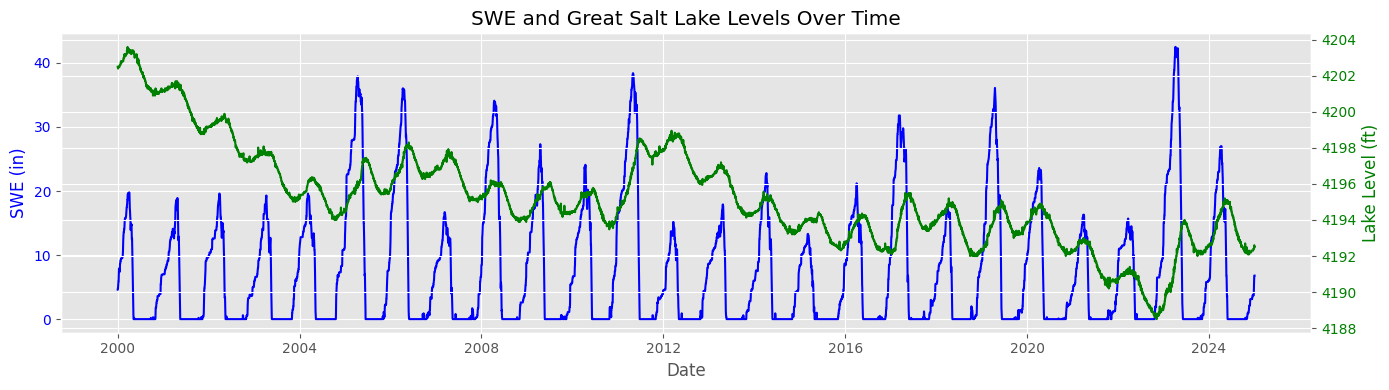

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 4))

# Create left axis for SWE data
ax1.plot(data['Date'], data['SWE'], 'b-', label='SWE (in)')
ax1.set_ylabel('SWE (in)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Create right axis for lake level data
ax2 = ax1.twinx()
ax2.plot(data['Date'], data['Level'], 'g-', label='Lake Level (ft)')
ax2.set_ylabel('Lake Level (ft)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Titles + formatting
ax1.set_xlabel('Date')
plt.title("SWE and Great Salt Lake Levels Over Time")
fig.tight_layout()
plt.show()

This plot is essentially a "zoomed in" version of the previous one, focusing in on the data from 2024 alone. It makes it eaier to see the "lag" between peak SWE levels and peak water levels in the lake. One interesting pattern is that while SWE levels seem to drop very abruptly each summer, water levels in the lake exhibit a more steady decline.

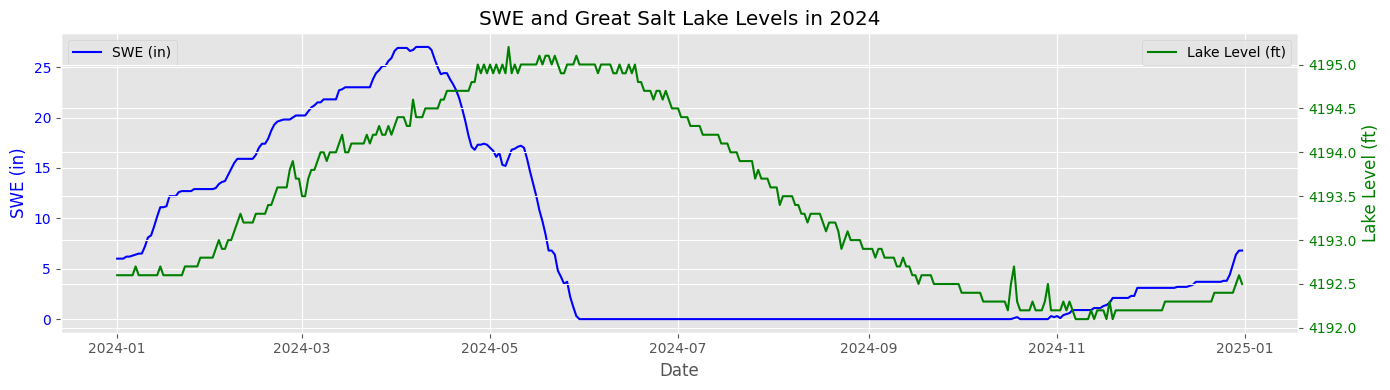

In [ ]:
# Filter to only include 2024 data
data2024 = data[data['Date'].dt.year == 2024]
fig, ax1 = plt.subplots(figsize=(14, 4))

# Create left axis for SWE data
ax1.plot(data2024['Date'], data2024['SWE'], label='SWE (in)', color='blue')
ax1.set_ylabel('SWE (in)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create right axis for lake level data
ax2 = ax1.twinx()
ax2.plot(data2024['Date'], data2024['Level'], label='Lake Level (ft)', color='green')
ax2.set_ylabel('Lake Level (ft)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Titles + formatting
ax1.set_xlabel('Date')
plt.title('SWE and Great Salt Lake Levels in 2024')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

##9. <font color="#83D3FE">Lagged Correlation Test + Visualization</font>
The purpose of the following experiment is to determine if changing the "lag" in the corrlation between SWE and lake levels has an effect on the correlation between the two variables. This was done by measuring the pearson correlation coefficient at different time delays (from 0 days to 200 days) and plotting all results.

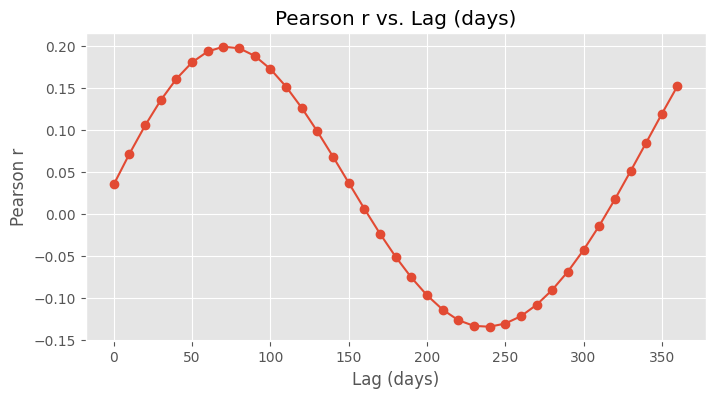


Highest correlation time delay:  70


In [ ]:
# Define lags and correlations list
lags = list(range(0, 365, 10))
correlations = []

# Compute pearson r for each lag
for lag in lags:
    temp = data[['SWE', 'Level']].copy()
    temp['SWE'] = temp['SWE'].shift(lag)  # apply lag
    temp = temp.dropna()                  # drop missing
    r, _ = pearsonr(temp['SWE'], temp['Level'])
    correlations.append(r)

# Simple line plot
plt.figure(figsize=(8, 4))
plt.plot(lags, correlations, 'o-')
plt.title("Pearson r vs. Lag (days)")
plt.xlabel("Lag (days)")
plt.ylabel("Pearson r")
plt.show()
print()
print("Highest correlation time delay: ",  lags[correlations.index(max(correlations))])

In [ ]:
# Find the highest correlation
best_r   = max(correlations)
best_lag = lags[correlations.index(best_r)]
print(f"Highest correlation: r = {best_r:.3f} at a {best_lag}-day lag")

Highest correlation: r = 0.199 at a 70-day lag


Because 70 days was the most correlated time delay, it will be used in the following experiments.

##10. <font color="#83D3FE">Linear Regression Test + Visualization</font>

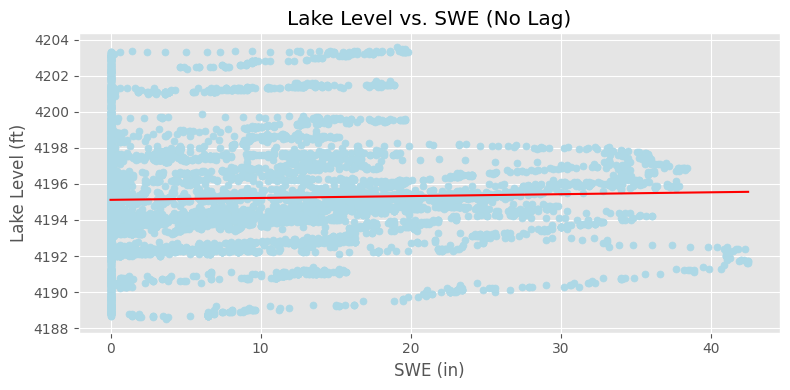

In [ ]:
# Define x and y
x = data['SWE'].values
y = data['Level'].values

# Fit the model
model = LinearRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], y)

# Prepare a line for plotting
xfit = np.linspace(x.min(), x.max(), 1000)
yfit = model.predict(xfit[:, np.newaxis])

# Plot data and regression line
plt.scatter(x, y, s=25,  color='lightblue')
plt.plot(xfit, yfit, color='r')
plt.title("Lake Level vs. SWE (No Lag)")
plt.xlabel("SWE (in)")
plt.ylabel("Lake Level (ft)")
plt.tight_layout()
plt.show()

This scatter plot compares snowpack 70 days ago (x-axis) with today’s lake level (y-axis). The upward trend means higher SWE generally leads to higher lake levels 70 days later. The red line is a straight-line fit showing that delay, though the spread of points shows other factors also affect lake height.

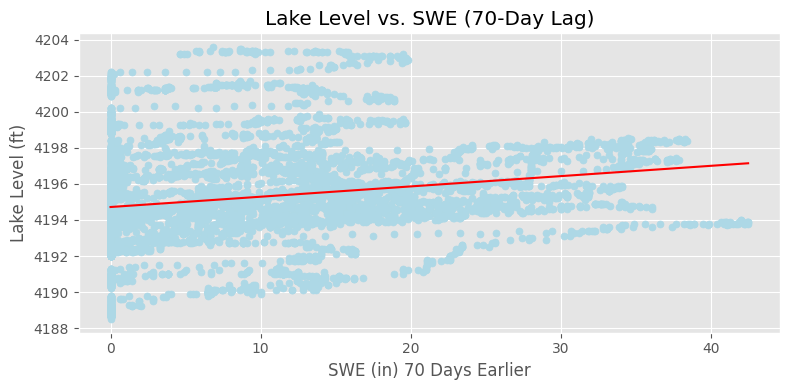

In [ ]:
# lagged version of SWE and drop the extra rows
df_lag = data[['SWE','Level']].copy()
df_lag['SWE'] = df_lag['SWE'].shift(70)
df_lag = df_lag.dropna()

# Define x and y using the lagged SWE
x = df_lag['SWE'].values
y = df_lag['Level'].values

# Fit the linear regression model
model = LinearRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], y)

# Prepare a smooth line for plotting the fit
xfit = np.linspace(x.min(), x.max(), 1000)
yfit = model.predict(xfit[:, np.newaxis])

# Plot the lagged data and the regression line
plt.scatter(x, y, s=25, color='lightblue')
plt.plot(xfit, yfit, color='r')
plt.title("Lake Level vs. SWE (70-Day Lag)")
plt.xlabel("SWE (in) 70 Days Earlier")
plt.ylabel("Lake Level (ft)")
plt.tight_layout()
plt.show()

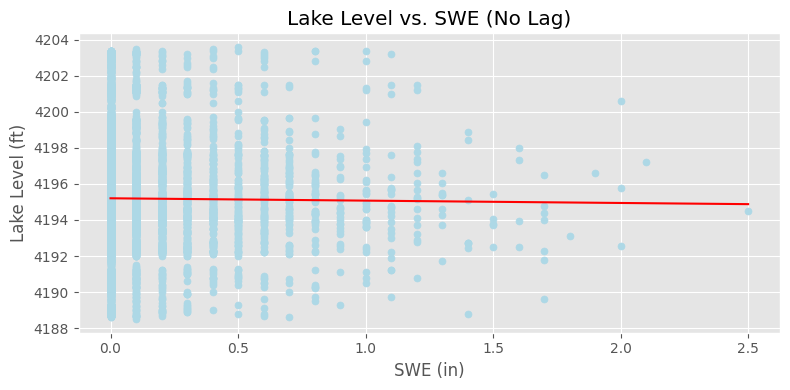

In [ ]:
# Define x and y
x = data['Precipitation'].values
y = data['Level'].values

# Fit the model
model = LinearRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], y)

# Prepare a line for plotting
xfit = np.linspace(x.min(), x.max(), 1000)
yfit = model.predict(xfit[:, np.newaxis])

# Plot data and regression line
plt.scatter(x, y, s=25,  color='lightblue')
plt.plot(xfit, yfit, color='r')
plt.title("Lake Level vs. SWE (No Lag)")
plt.xlabel("SWE (in)")
plt.ylabel("Lake Level (ft)")
plt.tight_layout()
plt.show()

##11. <font color="#83D3FE">Linear Regression Results</font>

In [ ]:
linear_regression_model = LinearRegression(fit_intercept=True)
# input: daily SWE (in)
x = data['SWE'].values.reshape(-1, 1)
# output: lake level (ft)
y = data['Level'].values
# fit the model to data
model.fit(x, y)
# predicted lake levels
y_pred = model.predict(x)
# sum of squared errors
sse = np.sum((y - y_pred) ** 2)
# total sum of squares
sst = np.sum((y - y.mean()) ** 2)
# r squared value
r2 = 1 - sse / sst

print("SWE vs Lake Level (no lag)")
print("Slope    : {0:.2f}".format(model.coef_[0]))
print("Intercept: {0:.2f}".format(model.intercept_))
print("R-squared: {0:.3f}".format(r2))
print()

SWE vs Lake Level (no lag)
Slope    : 0.01
Intercept: 4195.12
R-squared: 0.001



In [ ]:
linear_regression_model = LinearRegression(fit_intercept=True)
# input: daily SWE 70 days earlier (inches)
df_lag = data[['SWE', 'Level']].copy()
df_lag['SWE'] = df_lag['SWE'].shift(70)
df_lag = df_lag.dropna()
x = df_lag['SWE'].values.reshape(-1, 1)
# output: lake level (ft)
y = df_lag['Level'].values
# fit the model to data
linear_regression_model.fit(x, y)
# predicted lake levels
y_pred = linear_regression_model.predict(x)
# sum of squared errors
sse = np.sum((y - y_pred) ** 2)
# total sum of squares
sst = np.sum((y - y.mean()) ** 2)
# r squared value
r2 = 1 - sse / sst

print("SWE vs Lake Level (70-day lag)")
print("Slope    : {0:.2f}".format(linear_regression_model.coef_[0]))
print("Intercept: {0:.2f}".format(linear_regression_model.intercept_))
print("R-squared: {0:.3f}".format(r2))
print()

SWE vs Lake Level (70-day lag)
Slope    : 0.06
Intercept: 4194.72
R-squared: 0.040



In [ ]:
#Precipitation vs Lake Level (no lag)
linear_regression_model = LinearRegression(fit_intercept=True)
# input: daily precipitation (in)
x = data['Precipitation'].values.reshape(-1, 1)
# output: lake level (ft)
y = data['Level'].values
# fit the model to data
linear_regression_model.fit(x, y)
# predicted lake levels
y_pred = linear_regression_model.predict(x)
# sum of squared errors
sse = np.sum((y - y_pred) ** 2)
# total sum of squares
sst = np.sum((y - y.mean()) ** 2)
# r squared value
r2 = 1 - sse / sst

print("Precipitation vs Lake Level (no lag)")
print("Slope    : {0:.2f}".format(linear_regression_model.coef_[0]))
print("Intercept: {0:.2f}".format(linear_regression_model.intercept_))
print("R-squared: {0:.3f}".format(r2))

Precipitation vs Lake Level (no lag)
Slope    : -0.13
Intercept: 4195.20
R-squared: 0.000


##Write-up

<font color="#83D3FE">Introduction</font>

This project seeks to compare the impact of various factors on water levels in the Great Salt Lake. In this analysis, daily snow water equivalent (SWE) measurements from the mountains and daily precipitation records from Salt Lake County are paired with lake-level data from 01-01-2000 through 01-01-2025, to identify which variable has the strongest effect on lake elevation in the Great Salt Lake. This EDA uses several different analysis techniques, such as a lagged correlation analysis, linear regression analysis, normality test, and Pearson correlation test. It was found that snow water equivalent (SWE) has a very weak but significant relationship to water levels in the Great Salt Lake. Introducing a time delay of 70 days maximized the correlation between SWE levels and water levels in the lake. Precipitation and same-day SWE both showed essentially no immediate impact on lake levels.

<font color="#83D3FE">Why it Maters</font>

It is no secret that water levels in the Great Salt Lake have been steadily declining over the past few decades. As the shoreline retreats, more and more of the lakebed has been exposed, leaving fine dust, minerals, and salt on the surface. When the winds kick up, that fine dust is kicked up into the air, and tiny particles drift into nearby towns. This has posed a serious health threat to the general public, and the situation is only worsening. Because the lake collects runoff from across Utah, those dust clouds often carry pesticides, arsenic, selenium, and other toxins as well.

<font color="#83D3FE">Central Question</font>

The goal of this analysis is to better understand what factors affect water levels in the Great Salt Lake and how long it takes for snowmelt in the mountains to replenish the lake.

This analysis asks two central questions:

1. Which variable has the stronger relationship to Great Salt Lake elevation—mountain snowpack (SWE) or Salt Lake County precipitation?  
2. Is there a clear time lag between increases in snowpack and subsequent rises in the Great Salt Lake?

<font color="#83D3FE">Data Sources</font>

Data for this analysis was sourced from the U.S. Department of Agriculture NRCS SNOTEL Data as well as the Great Salt Lake Hydro Mapper (USGS). All three datasets in this report included daily data spanning the years of January 1, 2000 to January 1, 2025.  
The three datasets used were:

- **Brighton SNOTEL SWE**: The USDA NRCS SNOTEL system provides snow water equivalent (SWE), precipitation, and temperature data from automated stations called “SNOTELS” which are located in mountains all across the state. SWE measures how much water is contained in the snowpack if it were to melt, helping to predict how much water will be available in the coming months.  

- **Salt Lake County Precipitation**: Daily rainfall accumulation (inches) from a USDA NRCS SNOTEL station near the lake’s southern shore.  

- **Great Salt Lake Elevation**: The Great Salt Lake Hydro Mapper tracks long-term water level fluctuations in the lake. Users can download data directly into a CSV from the site.  

<font color="#83D3FE">Data Retrieval and Cleaning</font>

All three datasets in this experiment were downloaded from their respective organizations directly as CSV files and uploaded to GitHub for easy access. The data cleaning process was fairly simple. No interpolation was necessary as there were no missing values. To combine all three datasets into one dataset, each “Date” column was converted to datetime type, unnecessary columns were dropped, and then the three tables were merged on “Date” via an inner join. No missing values remained after this process.

<font color="#83D3FE">Visualization 1: Full-Period Time Series Line Graph</font>

The goal of this visualization was to see long-term trends and seasonality. The graph shows that there is an obvious pattern in both the water level and SWE data. SWE data tends to peak at the end of each spring, and water level data tends to peak in mid-summer. There is a clear decline in water levels over the past 25 years, while SWE declines at a slightly faster rate at the end of each cycle.

<font color="#83D3FE">Visualization 2: 2024 Time Series Line Graph</font>

The purpose of this visualization was to quantify the exact lag that maximizes correlation between SWE measurements and water levels in the Great Salt Lake. This plot shows how introducing various time delays shifts the SWE curve relative to the lake-level curve throughout 2024.

<font color="#83D3FE">Visualization 3: Lag-Correlation Graph</font>

This graph shows Pearson r values for time delays ranging from 0 to 360 days in 10-day increments. The highest Pearson correlation occurred at a 70-day delay.

<font color="#83D3FE">Visualization 4: No-Lag Scatter Plot and Regression Line</font>

The goal of this visualization was to investigate the immediate (same-day) relationship between SWE levels and lake elevation. The scatter plot of SWE vs. lake elevation shows a cloud of points with a very slight slope on the OLS fit line, indicating almost no same-day linear correlation.

<font color="#83D3FE">Visualization 5: 70-Day Lag Scatter Plot and Regression Line</font>

The goal here was to investigate the SWE–lake relationship with a 70-day lag. The scatter of SWE (shifted 70 days earlier) against today’s lake elevation shows a tighter clustering and a steeper regression slope, confirming a weak positive lagged correlation.

<font color="#83D3FE">Visualization 6: Precipitation versus Lake Level Scatter Plot and Regression Line</font>

This scatter plot shows same-day precipitation vs. lake elevation. The fit line slopes slightly downward, suggesting that rainfall has no positive same-day effect on lake level.

<font color="#83D3FE">Statistical Tests</font>

**Correlation Testing to Determine Time Delay**  
A series of Pearson correlation tests determined which time lag between SWE and lake elevation yielded the strongest linear relationship. Pearson’s method was chosen because the lagged SWE data approximated normality. The highest correlation occurred at a 70-day lag with r≈0.199 and p≈0, indicating a weak but statistically significant delayed effect.

**Regression Modeling to Determine Relationships Between Variables**  
- **Same-Day SWE**: slope = 0.01 ft/in, intercept = 4 195.12 ft, R² = 0.001  
- **70-Day-Lag SWE**: slope = 0.06 ft/in, intercept = 4 194.72 ft, R² = 0.04  
- **Same-Day Precipitation**: slope = –0.13 ft/in, intercept = 4 195.20 ft, R²≈0  

<font color="#83D3FE">Limitations</font>

There were several limitations of this analysis. First, SWE measurements came from only one station (Brighton). Second, precipitation data came from just one site in Salt Lake County. Third, factors such as evaporation, water withdrawals, groundwater infiltration, and runoff diversions were not included. Finally, the study assumes stable climate and water-management practices, which may not hold as temperatures rise.

<font color="#83D3FE">Conclusion</font>

The analysis found a statistically significant but weak relationship between mountain SWE and Great Salt Lake elevations. A 70-day lag produced the highest correlation (r = 0.199), suggesting snowmelt influences lake levels roughly two months later. Same-day SWE and precipitation showed almost no immediate effect.

<font color="#83D3FE">Sources</font>

https://wcc.sc.egov.usda.gov/nwcc/sensors  
https://www.sltrib.com/news/environment/2019/02/16/utah-snowpack-packed-with/  
https://www.nrcs.usda.gov/utah/snow-survey  
https://water.utah.gov/reservoirlevels/  
https://webapps.usgs.gov/gsl/data.html  
